In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
stock = 'C6L.SI'
data = yf.download(stock,period='10y',interval='1d')
assert isinstance(data, pd.DataFrame), "Data should be a pandas DataFrame"
data.head(3)
data.to_csv(stock + '.csv')

[*********************100%***********************]  1 of 1 completed


## Feature Engineering

In [3]:
# RSI
def RSI(data, period=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=2).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=2).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
data['RSI'] = RSI(data, period=14)

# MACD
def MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal
data['MACD'], data['MACD_Signal'] = MACD(data)

# moving average
def moving_average(data, window=20):
    return data['Close'].rolling(window=window, min_periods=1).mean()

data['MA5'] = moving_average(data, window=5)
data['MA10'] = moving_average(data, window=10)
data['MA20'] = moving_average(data, window=20)
data['MA50'] = moving_average(data, window=50)
data['MA100'] = moving_average(data, window=100)
data['MA200'] = moving_average(data, window=200)

# Bollinger Bands
def bollinger_bands(data, window=14, num_std_dev=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, lower_band
data['Upper_Band'], data['Lower_Band'] = bollinger_bands(data)

# Stochastic Oscillator
def stochastic_oscillator(data, k_window=14, d_window=3):
    low_min = data['Low'].rolling(window=k_window).min()
    high_max = data['High'].rolling(window=k_window).max()
    k = 100 * ((data['Close'] - low_min) / (high_max - low_min))
    d = k.rolling(window=d_window).mean()
    return k, d
data['%K'], data['%D'] = stochastic_oscillator(data)

# Average True Range (ATR)
def ATR(data, period=14):
    high_low = data['High'] - data['Low']
    high_close_prev = abs(data['High'] - data['Close'].shift(1))
    low_close_prev = abs(data['Low'] - data['Close'].shift(1))
    tr = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=2).mean()
    return atr
data['ATR'] = ATR(data)

# Commodity Channel Index (CCI)
def CCI(data, period=20):
    tp = (data['High'] + data['Low'] + data['Close']) / 3
    sma = tp.rolling(window=period, min_periods=1).mean()
    mad = abs(tp - sma).rolling(window=period, min_periods=1).mean()
    cci = (tp - sma) / (0.015 * mad)
    return cci
data['CCI'] = CCI(data)

# On-Balance Volume (OBV)
def OBV(data):
    obv = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()
    return obv
data['OBV'] = OBV(data)

# Rate of Change (ROC)
def ROC(data, period=12):
    roc = ((data['Close'] - data['Close'].shift(period)) / data['Close'].shift(period)) * 100
    return roc
data['ROC'] = ROC(data)

# Williams %R
def williams_r(data, period=14):
    highest_high = data['High'].rolling(window=period).max()
    lowest_low = data['Low'].rolling(window=period).min()
    r = ((highest_high - data['Close']) / (highest_high - lowest_low)) * -100
    return r
data['Williams_R'] = williams_r(data)

# Accumulation/Distribution Line (A/D Line)
def AD_Line(data):
    money_flow_multiplier = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / (data['High'] - data['Low'])
    money_flow_volume = money_flow_multiplier * data['Volume']
    ad_line = money_flow_volume.cumsum()
    return ad_line
data['AD_Line'] = AD_Line(data)

# Money Flow Index (MFI)
def MFI(data, period=14):
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    money_flow = typical_price * data['Volume']
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0).rolling(window=period).sum()
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0).rolling(window=period).sum()
    money_flow_ratio = positive_flow / negative_flow
    mfi = 100 - (100 / (1 + money_flow_ratio))
    return mfi
data['MFI'] = MFI(data)

# Parabolic SAR (Stop and Reverse)
def parabolic_sar(data, acceleration=0.02, acceleration_max=0.2):
    sar = pd.Series(index=data.index)
    uptrend = True
    sar[0] = data['Low'][0] - ATR(data, period=14)[0]  # Initial SAR value (arbitrary)
    ep = data['High'][0]  # Initial extreme point (highest high in uptrend)
    accel = acceleration

    for i in range(1, len(data)):
        if uptrend:
            sar[i] = sar[i-1] + accel * (ep - sar[i-1])
            if data['Low'][i] < sar[i]:
                uptrend = False
                sar[i] = ep
                ep = data['Low'][i]
                accel = acceleration
            elif data['High'][i] > ep:
                ep = data['High'][i]
                accel = min(accel + acceleration, acceleration_max)
        else:  # Downtrend
            sar[i] = sar[i-1] + accel * (ep - sar[i-1])
            if data['High'][i] > sar[i]:
                uptrend = True
                sar[i] = ep
                ep = data['High'][i]
                accel = acceleration
            elif data['Low'][i] < ep:
                ep = data['Low'][i]
                accel = min(accel + acceleration, acceleration_max)
    return sar
# data['SAR'] = parabolic_sar(data)

# Average Directional Index (ADX)
def ADX(data, period=14):
    delta = data['Close'].diff()
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)

    tr = pd.concat([data['High'] - data['Low'], abs(data['High'] - data['Close'].shift(1)), abs(data['Low'] - data['Close'].shift(1))], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()

    plus_dm = up.rolling(window=period, min_periods=1).sum()
    minus_dm = down.rolling(window=period, min_periods=1).sum()

    plus_di = (plus_dm / atr) * 100
    minus_di = (minus_dm / atr) * 100

    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period, min_periods=1).mean()

    return adx, plus_di, minus_di
# data['ADX'], data['+DI'], data['-DI'] = ADX(data)

# Ichimoku Cloud (Simplified - only Senkou Spans)
def ichimoku_cloud(data, tenkan_period=9, kijun_period=26, senkou_b_period=52):
    high_9 = data['High'].rolling(window=tenkan_period).max()
    low_9 = data['Low'].rolling(window=tenkan_period).min()
    tenkan_sen = (high_9 + low_9) / 2

    high_26 = data['High'].rolling(window=kijun_period).max()
    low_26 = data['Low'].rolling(window=kijun_period).min()
    kijun_sen = (high_26 + low_26) / 2

    senkou_span_a = ((tenkan_sen + kijun_sen) / 2).shift(kijun_period)

    high_52 = data['High'].rolling(window=senkou_b_period).max()
    low_52 = data['Low'].rolling(window=senkou_b_period).min()
    senkou_span_b = ((high_52 + low_52) / 2).shift(kijun_period)

    return senkou_span_a, senkou_span_b
data['Senkou_A'], data['Senkou_B'] = ichimoku_cloud(data)

In [4]:
data.dropna(inplace=True)

In [5]:
data.shape

(685, 27)

In [16]:
from os import name
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM, Dense, Dropout, Layer
from tensorflow.keras.models import Sequential


class InputAttention(Layer):
    def __init__(self, units, **kwargs) -> None:
        self.units = units
        super(InputAttention, self).__init__(**kwargs)

    def build(self, input_shape) -> None:
        self.W = self.add_weight(
            shape=(input_shape[-1], self.units), initializer="normal", trainable=True, name="attention_W"
        )
        self.b = self.add_weight(shape=(self.units,), initializer="zeros", trainable=True, name="attention_b")
        self.v = self.add_weight(shape=(self.units,), initializer="normal", trainable=True, name="attention_v")
        super(InputAttention, self).build(input_shape)

    def call(self, inputs):
        # inputs.shape = (batch_size, time_steps, features)
        e = K.tanh(K.dot(inputs, self.W) + self.b)
        # e.shape = (batch_size, time_steps, units)
        alpha = K.softmax(K.dot(e, K.expand_dims(self.v, axis=-1)), axis=1)
        # alpha.shape = (batch_size, time_steps, 1)
        output = inputs * alpha
        # output.shape = (batch_size, time_steps, features)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape


class Attention(Layer):
    """
    Custom Attention Layer (Self-Attention style).
    Projects input to query, key, value and computes attention output.
    Output shape: (batch_size, time_steps, units)
    """

    def __init__(self, units, **kwargs) -> None:
        super(Attention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape) -> None:
        # input_shape: (batch_size, time_steps, features)
        self.query_dense = Dense(self.units)
        self.key_dense = Dense(self.units)
        self.value_dense = Dense(self.units)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, time_steps, features)
        query = self.query_dense(inputs)  # (batch_size, time_steps, units)
        key = self.key_dense(inputs)  # (batch_size, time_steps, units)
        value = self.value_dense(inputs)  # (batch_size, time_steps, units)

        # Scaled dot-product attention
        scores = tf.matmul(query, key, transpose_b=True)  # (batch, time, time)
        dk = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_scores = scores / tf.math.sqrt(dk)
        weights = tf.nn.softmax(scaled_scores, axis=-1)  # (batch, time, time)
        output = tf.matmul(weights, value)  # (batch, time, units)
        return output

    def compute_output_shape(self, input_shape):
        # Output: (batch_size, time_steps, units)
        # return (input_shape[0], input_shape[1], self.units)
        return input_shape

class FuzzyMembershipLayer(Layer):
    def __init__(self, num_memberships=3, **kwargs):
        super().__init__(**kwargs)
        self.num_memberships = num_memberships  # e.g., low/medium/high

    def build(self, input_shape):
        # One mean and sigma per input feature per membership function
        self.means = self.add_weight(
            shape=(input_shape[-1], self.num_memberships),
            initializer="random_normal",
            trainable=True,
            name="fuzzy_means"
        )
        self.sigmas = self.add_weight(
            shape=(input_shape[-1], self.num_memberships),
            initializer="ones",
            trainable=True,
            name="fuzzy_sigmas"
        )
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (batch, time, features) or (batch, features)
        # Expand dims for broadcasting: (batch, ..., features, 1)
        x = tf.expand_dims(inputs, -1)
        # Gaussian membership: exp(-0.5 * ((x - mean)/sigma)^2)
        memberships = tf.exp(-0.5 * tf.square((x - self.means) / (self.sigmas + 1e-6)))
        # Output shape: (batch, ..., features, num_memberships)
        return memberships

from tensorflow.keras.layers import Layer, Lambda

class DefuzzificationLayer(Layer):
    """
    Simple defuzzification layer using weighted average.
    Assumes input shape: (batch, time, features, num_memberships)
    Outputs: (batch, time, features)
    """
    def __init__(self, num_memberships=3, **kwargs):
        super().__init__(**kwargs)
        # Defuzzification weights (e.g., [0, 0.5, 1] for low/med/high)
        self.defuzz_weights = self.add_weight(
            shape=(num_memberships,),
            initializer=tf.keras.initializers.Constant([i/(num_memberships-1) for i in range(num_memberships)]),
            trainable=True,
            name="defuzz_weights"
        )

    def call(self, inputs):
        # Weighted sum over the membership axis
        return tf.reduce_sum(inputs * self.defuzz_weights, axis=-1)

import numpy as np
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.python.data.ops.dataset_ops import DatasetV2


class StockPricePredictor:
    """
    A class that defines and instantiates an RNN model (LSTM) for predicting stock prices.
    """

    def __init__(
        self,
        sequence_length: int,
        prediction_length: int = 3,
        num_features: int = 4,
        lstm_units: int = 256,
        dropout_rate: float = 0.2,
    ) -> None:
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.num_features = num_features
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.model = self._build_model()

    def _build_model(self):
        """
        Builds the RNN model (LSTM) using TensorFlow's Keras API.  This is a *private* method,
        indicated by the leading underscore.  It should only be called from within the class.

        Returns:
            tf.keras.Model: The compiled RNN model.
        """
        model = Sequential()
        # Add an LSTM layer with dropout
        model.add(Input(shape=(self.sequence_length, self.num_features)))
        # model.add(FuzzyMembershipLayer(num_memberships=8))
        model.add(InputAttention(units=self.lstm_units))
        # model.add(DefuzzificationLayer(num_memberships=8))

        model.add(
            LSTM(units=self.lstm_units, return_sequences=True)
        )  # Important to return sequences for stacking LSTM layers
        model.add(Dropout(self.dropout_rate))

        model.add(Attention(units=self.lstm_units))

        # Add a second LSTM layer with dropout
        model.add(LSTM(units=self.lstm_units, return_sequences=False))
        model.add(Dropout(self.dropout_rate))

        # Add a Dense layer for the output (predicting the next day's closing price)
        model.add(Dense(units=self.prediction_length))

        # Compile the model
        model.compile(optimizer=Adam(), loss="mean_squared_error")
        return model

    def prepare_sequences(self, data: np.ndarray) -> np.ndarray:
        """
        Prepares input data into sequences of the specified length.

        Args:
            data (numpy.ndarray): The input time series data.

        Returns:
            numpy.ndarray: An array of sequences with shape
                           (num_sequences, sequence_length, num_features).
        """
        num_sequences = len(data) - self.sequence_length
        if num_sequences < 0:
            raise ValueError(
                f"Input data length ({len(data)}) must be greater than or equal to sequence length ({self.sequence_length})."
            )
        sequences = np.array([data[i : i + self.sequence_length] for i in range(num_sequences)])
        return sequences

    def prepare_dataset(self, x_data: np.ndarray, y_data: np.ndarray, batch_size: int) -> DatasetV2:
        """
        Prepares the dataset for training.

        Args:
            x_data (numpy.ndarray): The input features.
            y_data (numpy.ndarray): The target values.
            batch_size (int): The batch size.

        Returns:
            tf.data.Dataset: A TensorFlow Dataset object.
        """
        data_x = []
        data_y = []
        for i in range(len(x_data) - self.sequence_length - self.prediction_length + 1):
            data_x.append(x_data[i : i + self.sequence_length])
            data_y.append(y_data[i + self.sequence_length : i + self.sequence_length + self.prediction_length])

        ds_x = tf.data.Dataset.from_tensor_slices(np.array(data_x))
        ds_y = tf.data.Dataset.from_tensor_slices(np.array(data_y))
        dataset = tf.data.Dataset.zip((ds_x, ds_y)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

    def train(
        self,
        x_train: np.ndarray,
        y_train: np.ndarray,
        epochs: int = 100,
        batch_size: int = 32,
        validation_data=None,
        callbacks=None,
    ):
        """
        Trains the RNN model.

        Args:
            x_train (numpy.ndarray): The training input data.
            y_train (numpy.ndarray): The training output data.
            epochs (int, optional): The number of epochs to train for. Defaults to 100.
            batch_size (int, optional): The batch size to use. Defaults to 32.
            validation_data (tuple, optional): Validation data (x_val, y_val) for monitoring performance. Defaults to None.
            callbacks (list, optional): List of Keras callbacks to apply during training. Defaults to None.

        Returns:
            tf.keras.callbacks.History: The training history object.
        """
        train_dataset = self.prepare_dataset(x_train, y_train, batch_size)
        val_dataset = None
        if validation_data is not None:
            x_val, y_val = validation_data
            val_dataset = self.prepare_dataset(x_val, y_val, batch_size)

        # Train the model
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            validation_data=val_dataset,
            callbacks=callbacks,
        )
        return history

    def predict(self, x_test):
        """
        Makes predictions using the trained RNN model.

        Args:
            x_test (numpy.ndarray): The test input data.

        Returns:
            numpy.ndarray: The predicted stock prices.
        """
        if len(x_test) < self.sequence_length:
            raise ValueError(
                f"Input test data length ({len(x_test)}) must be at least the sequence length ({self.sequence_length}) "
                f"to make a prediction."
            )

        # Prepare the test data into sequences
        test_sequences = self.prepare_sequences(x_test)

        # Make predictions on the prepared sequences
        predictions = self.model.predict(test_sequences)
        return predictions

    def evaluate(self, x_test, y_test) -> float:
        """
        Evaluates the trained RNN model.

        Args:
            x_test (numpy.ndarray): The test input data.
            y_test (numpy.ndarray): The test output data.

        Returns:
            float: The loss value on the test data.
        """
        test_dataset = self.prepare_dataset(x_test, y_test, batch_size=len(x_test))
        loss = self.model.evaluate(test_dataset)
        return loss

    def save_model(self, filepath: str) -> None:
        """
        Saves the trained model to a file.

        Args:
            filepath (str): The path to save the model to.
        """
        self.model.save(filepath)

    def load_model(self, filepath: str) -> None:
        """
        Loads a trained model from a file.

        Args:
            filepath (str): The path to load the model from.
        """
        self.model = tf.keras.models.load_model(filepath)


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, data["Close"], test_size=0.2, random_state=42, shuffle=False)
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, shuffle=False)

In [17]:
predictor = StockPricePredictor(
    sequence_length=30, num_features=x_train.shape[1], lstm_units=512,
)

In [18]:
predictor.model.summary(expand_nested=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_attention_1               │ (None, 30, 27)         │        14,848 │
│ (InputAttention)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 512)        │     1,105,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 30, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,221,507 (12.29 MB)

 Trainable params: 3,221,507 (12.29 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)


history = predictor.train(
    x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping]
)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.0306 - val_loss: 8.8549e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0045 - val_loss: 0.0076
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 6.8205e-04 - val_loss: 0.0032
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 6.1890e-04 - val_loss: 0.0041
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 3.6061e-04 - val_loss: 0.0036
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 5.4194e-04 - val_loss: 0.0038
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 3.3299e-04 - val_loss: 0.0025
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 3.4998e-04 - val_loss: 0.0028
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 3.5819e-04 - val_loss: 0.0032
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 3.4639e-04 - val_loss: 0.0025
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 3.0126e-04 - val_loss: 0.0021


In [20]:
predictions = predictor.predict(np.concat([x_train[-30:], x_test], axis=0))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [21]:
loss = predictor.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
predictor.save_model("RNN_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0048
Test Loss: 0.004849778488278389


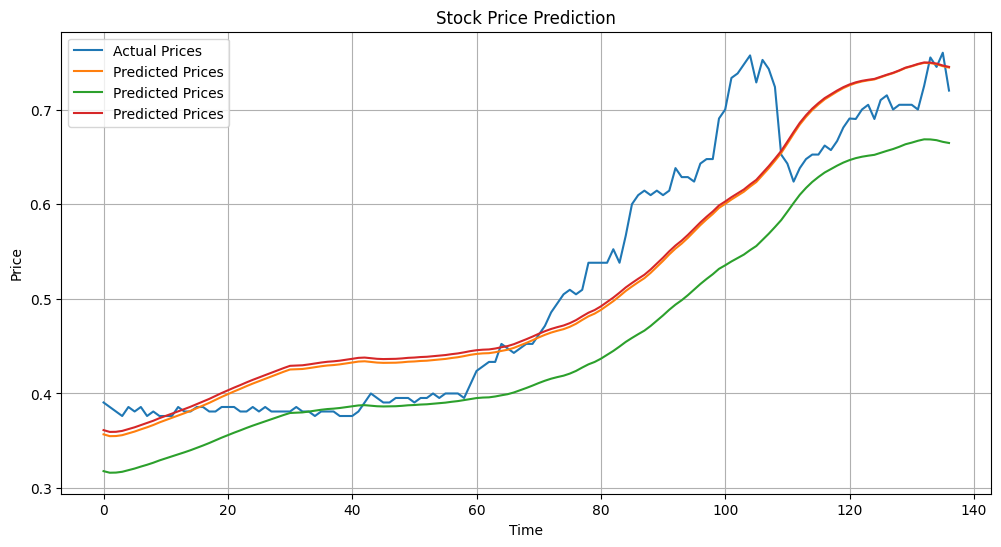

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Prices")
plt.plot(predictions, label="Predicted Prices")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

In [25]:
tickers = ['YF8.SI', 'AAPL', 'GOOG', 'MSFT', 'TSLA', 'AMZN', 'META', 'NVDA', 'BABA', 'JPM']
stock_data = {}

for ticker in tickers:
    df = yf.download(ticker, period='5y', interval='1d')
    # Feature engineering
    df['RSI'] = RSI(df, period=14)
    df['MACD'], df['MACD_Signal'] = MACD(df)
    df['MA5'] = moving_average(df, window=5)
    df['MA10'] = moving_average(df, window=10)
    df['MA20'] = moving_average(df, window=20)
    df['MA50'] = moving_average(df, window=50)
    df['MA100'] = moving_average(df, window=100)
    df['MA200'] = moving_average(df, window=200)
    df['Upper_Band'], df['Lower_Band'] = bollinger_bands(df)
    df['%K'], df['%D'] = stochastic_oscillator(df)
    df['ATR'] = ATR(df)
    df['CCI'] = CCI(df)
    df['OBV'] = OBV(df)
    df['ROC'] = ROC(df)
    df['Williams_R'] = williams_r(df)
    df['AD_Line'] = AD_Line(df)
    df['MFI'] = MFI(df)
    df['Senkou_A'], df['Senkou_B'] = ichimoku_cloud(df)
    df.dropna(inplace=True)
    stock_data[ticker] = df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
